In [1]:
import os
import sys
from pathlib import Path

# Get the absolute path to project root directory
project_root = str(Path(os.getcwd()).resolve().parents[0])  # Go up one level if notebook is in subdirectory
if os.getcwd() == project_root:
    project_root = os.getcwd()  # If notebook is in root directory

# Add project root to path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_cleaning.data_cleaning import clean_data
from feature_engineering import engineer_features
from utils.load_data import load_data

In [3]:
train_df = load_data("data/train.csv")
test_df = load_data("data/test.csv")
train_df = engineer_features(train_df)
train_df = clean_data(train_df)
test_df = engineer_features(test_df)
test_df = clean_data(test_df)
df = train_df[~train_df["lot_frontage_missing"] == 1]
df_test = test_df[~test_df["lot_frontage_missing"] == 1]

In [4]:
df.shape

(1201, 91)

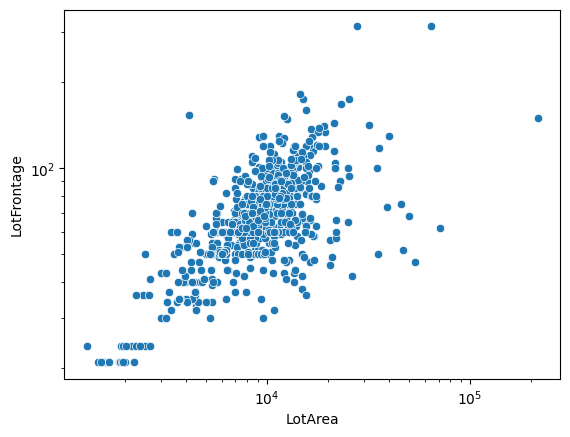

In [5]:
sns.scatterplot(data=df, x="LotArea", y="LotFrontage")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [6]:
# log(LotFrontage) and log(LotArea) has clear relationship, but with unequal variances

In [7]:
# Cheking relationships of LotArea with different categorical variables

In [8]:
import warnings

from scipy import stats

# Suppress warnings about unequal variances - we'll handle this in our interpretation
warnings.filterwarnings("ignore", category=UserWarning)


def perform_anova_tests(df, target_col, categorical_cols):
    """
    Perform ANOVA tests for target column against multiple categorical columns.
    Returns results sorted by p-value.
    """
    results = []

    for cat_col in categorical_cols:
        # Create groups for ANOVA
        groups = []
        unique_categories = df[cat_col].dropna().unique()

        # Get data for each category
        for category in unique_categories:
            group_data = df[df[cat_col] == category][target_col].dropna()
            if len(group_data) > 0:  # Only include groups with data
                groups.append(group_data)

        if len(groups) >= 2:  # ANOVA requires at least 2 groups
            try:
                f_stat, p_value = stats.f_oneway(*groups)

                # Calculate effect size (eta-squared)
                # First calculate overall mean and total sum of squares
                all_values = np.concatenate(groups)
                grand_mean = np.mean(all_values)
                total_ss = np.sum((all_values - grand_mean) ** 2)

                # Calculate between-groups sum of squares
                between_ss = sum(
                    len(g) * (np.mean(g) - grand_mean) ** 2 for g in groups
                )

                # Calculate eta-squared
                eta_squared = between_ss / total_ss

                results.append(
                    {
                        "Variable": cat_col,
                        "F_statistic": f_stat,
                        "p_value": p_value,
                        "eta_squared": eta_squared,
                        "n_groups": len(groups),
                        "min_group_size": min(len(g) for g in groups),
                        "max_group_size": max(len(g) for g in groups),
                    }
                )
            except Exception as e:
                print(f"Error processing {cat_col}: {str(e)}")

    # Convert to DataFrame and sort by p-value
    results_df = pd.DataFrame(results).sort_values("p_value")
    return results_df


# Read the data

# List of categorical variables to test
categorical_vars = [
    "LotShape",
    "LandContour",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "BldgType",
    "HouseStyle",
]

# Perform ANOVA tests
results = perform_anova_tests(df, "LotFrontage", categorical_vars)

# Format results for display
pd.set_option("display.max_rows", None)
pd.set_option(
    "display.float_format",
    lambda x: "{:.2e}".format(x) if abs(x) < 0.01 else "{:.4f}".format(x),
)

print("\nANOVA Test Results:")
print("===================")
print(
    "\nNull Hypothesis: LotFrontage means are equal across all groups in each variable"
)
print("Alternative Hypothesis: At least one group has a different mean LotFrontage\n")
print(
    results[
        [
            "Variable",
            "F_statistic",
            "p_value",
            "eta_squared",
            "n_groups",
            "min_group_size",
            "max_group_size",
        ]
    ]
)

# Additional analysis for significant relationships
alpha = 0.05
significant_vars = results[results["p_value"] < alpha]["Variable"].tolist()

print("\nSignificant Variables (p < 0.05):")
print("=================================")
for var in significant_vars:
    group_stats = (
        df.groupby(var, observed=True)["LotFrontage"]
        .agg(["count", "mean", "std"])
        .round(2)
    )
    print(f"\n{var} - Group Statistics:")
    print(group_stats)


ANOVA Test Results:

Null Hypothesis: LotFrontage means are equal across all groups in each variable
Alternative Hypothesis: At least one group has a different mean LotFrontage

       Variable  F_statistic  p_value  eta_squared  n_groups  min_group_size  \
6      BldgType      98.2587 2.39e-72       0.2473         5              28   
4  Neighborhood      14.3406 1.94e-50       0.2264        25               2   
0      LotShape      32.3728 4.04e-20       0.0750         4               7   
2     LotConfig      22.9157 2.89e-18       0.0712         5               4   
5    Condition1       8.7172 1.26e-11       0.0553         9               1   
7    HouseStyle       4.4985 5.84e-05       0.0257         8               8   
1   LandContour       4.4251 4.21e-03       0.0110         4              17   
3     LandSlope       4.8309 8.14e-03     8.00e-03         3               5   

   max_group_size  
6             994  
4             186  
0             851  
2             918  


In [9]:
# BldgType and Neighborhood shown both significant relationships with LotFrontage and variance explanation.
# LotShape and LotConfig have significant relationships with LotFrontage

In [10]:
# Creating Random Forest imputer for LotFrontage based on log(LotArea), BldgType and Neighborhood

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def prepare_features(df):
    """Prepare features for the model."""
    # Create dummy variables
    X = pd.get_dummies(df[["BldgType", "Neighborhood"]], drop_first=False)
    X["log_LotArea"] = np.log(df["LotArea"])
    return X


def prepare_target(df):
    """Prepare target variable."""
    return np.log(df["LotFrontage"])


def evaluate_predictions(y_true, y_pred):
    """Calculate various metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Calculate RMSE in original scale
    rmse_original = np.exp(rmse)

    return {
        "MSE (log scale)": mse,
        "RMSE (log scale)": rmse,
        "RMSE (feet)": rmse_original,
        "R²": r2,
    }


# Prepare features and target for both sets
X_train = prepare_features(df)
y_train = prepare_target(df)

X_test = prepare_features(df_test)
y_test = prepare_target(df_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

# Evaluate on both sets
train_metrics = evaluate_predictions(y_train, train_pred)
test_metrics = evaluate_predictions(y_test, test_pred)

print("\nTraining Set Metrics:")
print("=====================")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
print("=================")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf.feature_importances_}
).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print("==============================")
print(feature_importance.head(10))

# Check for overfitting
print("\nOverfitting Analysis:")
print("====================")
print(
    f"RMSE difference (test - train): {test_metrics['RMSE (log scale)'] - train_metrics['RMSE (log scale)']:.4f}"
)
print(f"R² difference (train - test): {train_metrics['R²'] - test_metrics['R²']:.4f}")


Training Set Metrics:
MSE (log scale): 0.0070
RMSE (log scale): 0.0837
RMSE (feet): 1.0873
R²: 0.9436

Test Set Metrics:
MSE (log scale): 0.0413
RMSE (log scale): 0.2033
RMSE (feet): 1.2255
R²: 0.6848

Top 10 Most Important Features:
                 feature  importance
30           log_LotArea      0.8271
22  Neighborhood_OldTown      0.0146
0          BldgType_1Fam      0.0142
4        BldgType_TwnhsE      0.0136
21  Neighborhood_NridgHt      0.0132
17    Neighborhood_NAmes      0.0128
12  Neighborhood_Edwards      0.0116
13  Neighborhood_Gilbert    8.26e-03
28   Neighborhood_Timber    6.89e-03
10  Neighborhood_CollgCr    6.82e-03

Overfitting Analysis:
RMSE difference (test - train): 0.1196
R² difference (train - test): 0.2589


In [12]:
lot_frontage_range = df["LotFrontage"].max() - df["LotFrontage"].min()
lot_frontage_range

292.0

In [13]:
Q1 = df["LotFrontage"].quantile(0.25)
Q3 = df["LotFrontage"].quantile(0.75)
IQR = Q3 - Q1
IQR

21.0

In [14]:
1.2254 / IQR

0.058352380952380954

In [15]:
1.2254 / lot_frontage_range

0.004196575342465754

In [16]:
# First imputer is not bad. RMSE is 1.2254 feet, which is 0.4% of the whole range of LotArea and 6% of IQR

In [17]:
# Attempt to reduce RF imputer overfitting.

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def prepare_data(df):
    """Prepare features and target."""
    X = pd.get_dummies(df[["BldgType", "Neighborhood"]], drop_first=False)
    X["log_LotArea"] = np.log(df["LotArea"])
    y = np.log(df["LotFrontage"])
    return X, y


def evaluate_model(y_true, y_pred):
    """Calculate metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    rmse_feet = np.exp(rmse)
    return {"MSE": mse, "RMSE": rmse, "RMSE_feet": rmse_feet, "R2": r2}


# Prepare data
X_train, y_train = prepare_data(df)
X_test, y_test = prepare_data(df_test)

# Define different model configurations
configs = [
    {"name": "Baseline", "params": {"n_estimators": 100, "random_state": 42}},
    {
        "name": "More Leaf Samples",
        "params": {"n_estimators": 100, "min_samples_leaf": 5, "random_state": 42},
    },
    {
        "name": "More Split Samples",
        "params": {"n_estimators": 100, "min_samples_split": 10, "random_state": 42},
    },
    {
        "name": "Limited Depth",
        "params": {"n_estimators": 100, "max_depth": 10, "random_state": 42},
    },
    {
        "name": "Combined Restrictions",
        "params": {
            "n_estimators": 100,
            "min_samples_leaf": 3,
            "min_samples_split": 8,
            "max_depth": 12,
            "random_state": 42,
        },
    },
    {
        "name": "Aggressive Restrictions",
        "params": {
            "n_estimators": 100,
            "min_samples_leaf": 5,
            "min_samples_split": 10,
            "max_depth": 8,
            "random_state": 42,
        },
    },
]

results = []

# Test each configuration
for config in configs:
    rf = RandomForestRegressor(**config["params"])
    rf.fit(X_train, y_train)

    # Get predictions
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)

    # Calculate metrics
    train_metrics = evaluate_model(y_train, train_pred)
    test_metrics = evaluate_model(y_test, test_pred)

    # Calculate overfitting measures
    rmse_diff = test_metrics["RMSE"] - train_metrics["RMSE"]
    r2_diff = train_metrics["R2"] - test_metrics["R2"]

    results.append(
        {
            "Model": config["name"],
            "Train_RMSE": train_metrics["RMSE"],
            "Test_RMSE": test_metrics["RMSE"],
            "Train_RMSE_feet": train_metrics["RMSE_feet"],
            "Test_RMSE_feet": test_metrics["RMSE_feet"],
            "Train_R2": train_metrics["R2"],
            "Test_R2": test_metrics["R2"],
            "RMSE_diff": rmse_diff,
            "R2_diff": r2_diff,
        }
    )

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

print("\nModel Comparison:")
print("================")
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))
print(results_df)

# Find best model based on test RMSE
best_model = results_df.loc[results_df["Test_RMSE"].idxmin()]
print("\nBest Model (by Test RMSE):")
print("=========================")
print(f"Configuration: {best_model['Model']}")
print(f"Test RMSE (log scale): {best_model['Test_RMSE']:.4f}")
print(f"Test RMSE (feet): {best_model['Test_RMSE_feet']:.4f}")
print(f"Test R²: {best_model['Test_R2']:.4f}")
print(f"Overfitting (RMSE diff): {best_model['RMSE_diff']:.4f}")
print(f"Overfitting (R² diff): {best_model['R2_diff']:.4f}")


Model Comparison:
                     Model  Train_RMSE  Test_RMSE  Train_RMSE_feet  \
0                 Baseline      0.0837     0.2033           1.0873   
1        More Leaf Samples      0.1707     0.2005           1.1862   
2       More Split Samples      0.1357     0.1969           1.1454   
3            Limited Depth      0.1425     0.1962           1.1531   
4    Combined Restrictions      0.1626     0.1992           1.1765   
5  Aggressive Restrictions      0.1838     0.1985           1.2017   

   Test_RMSE_feet  Train_R2  Test_R2  RMSE_diff  R2_diff  
0          1.2255    0.9436   0.6848     0.1196   0.2589  
1          1.2220    0.7657   0.6936     0.0297   0.0720  
2          1.2176    0.8519   0.7044     0.0612   0.1474  
3          1.2168    0.8368   0.7066     0.0537   0.1302  
4          1.2204    0.7875   0.6976     0.0366   0.0899  
5          1.2195    0.7285   0.6997     0.0147   0.0288  

Best Model (by Test RMSE):
Configuration: Limited Depth
Test RMSE (log scale

In [19]:
# Investigation of LotFrontage missingness pattern

In [20]:
import numpy as np
import pandas as pd
from scipy import stats


def analyze_categorical_missingness(df, cat_var):
    """Analyze missingness patterns in categorical variables."""
    # Create missingness indicator
    missing = df["LotFrontage"].isna()

    # Calculate proportions of missing values for each category
    missing_props = (
        df.groupby(cat_var)["LotFrontage"]
        .apply(lambda x: x.isna().mean())
        .sort_values(ascending=False)
    )
    counts = df.groupby(cat_var).size()

    # Combine proportions and counts
    result = pd.DataFrame({"Missing_Proportion": missing_props, "Total_Count": counts})

    # Chi-square test
    contingency = pd.crosstab(df[cat_var], missing)
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    return result, p_value


def analyze_numeric_missingness(df, num_var):
    """Analyze missingness patterns in numeric variables."""
    # Split into groups with and without missing LotFrontage
    missing_mask = df["LotFrontage"].isna()
    present_values = df[~missing_mask][num_var]
    missing_values = df[missing_mask][num_var]

    # Calculate summary statistics
    stats_df = pd.DataFrame(
        {
            "Present_Mean": [present_values.mean()],
            "Missing_Mean": [missing_values.mean()],
            "Present_Median": [present_values.median()],
            "Missing_Median": [missing_values.median()],
            "Present_Std": [present_values.std()],
            "Missing_Std": [missing_values.std()],
        }
    )

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(present_values, missing_values)

    return stats_df, p_value


# Read original data (before any imputation)
train_df = pd.read_csv("./data/train.csv")

# Categorical variables to analyze
cat_vars = ["Neighborhood", "BldgType", "LotShape", "LotConfig", "LandContour"]

print("Analysis of Categorical Variables:")
print("=================================")
for var in cat_vars:
    result, p_value = analyze_categorical_missingness(train_df, var)
    print(f"\n{var} Analysis:")
    print("-" * (len(var) + 9))
    print("\nProportion of missing LotFrontage by category:")
    print(result)
    print(f"\nChi-square test p-value: {p_value:.4e}")
    print("\nCategories with highest missingness:")
    print(result.nlargest(3, "Missing_Proportion"))

# Numeric variables to analyze
num_vars = ["LotArea", "YearBuilt", "OverallQual"]

print("\n\nAnalysis of Numeric Variables:")
print("=============================")
for var in num_vars:
    stats_df, p_value = analyze_numeric_missingness(train_df, var)
    print(f"\n{var} Analysis:")
    print("-" * (len(var) + 9))
    print("\nSummary Statistics:")
    print(stats_df)
    print(f"\nt-test p-value: {p_value:.4e}")

# Additional analysis: Missing patterns over time
print("\n\nTemporal Analysis:")
print("=================")
year_groups = pd.qcut(train_df["YearBuilt"], q=4)
temporal_missing = train_df.groupby(year_groups, observed=True)["LotFrontage"].apply(
    lambda x: x.isna().mean()
)
print("\nMissing proportion by construction period:")
print(temporal_missing)

Analysis of Categorical Variables:

Neighborhood Analysis:
---------------------

Proportion of missing LotFrontage by category:
              Missing_Proportion  Total_Count
Neighborhood                                 
Blmngtn                   0.1765           17
Blueste                   0.0000            2
BrDale                    0.0000           16
BrkSide                   0.1207           58
ClearCr                   0.5357           28
CollgCr                   0.1600          150
Crawfor                   0.1961           51
Edwards                   0.0800          100
Gilbert                   0.3797           79
IDOTRR                    0.0811           37
MeadowV                   0.1176           17
Mitchel                   0.2653           49
NAmes                     0.1733          225
NPkVill                   0.2222            9
NWAmes                    0.3836           73
NoRidge                   0.1951           41
NridgHt                   0.0130           

In [21]:
# This suggests the missingness mechanism is MNAR and related to:
#  Irregular/difficult to measure lots (cul-de-sacs, irregular shapes, low-lying areas)
#  Larger lots (possibly harder to measure or more complex boundaries)
#  Specific neighborhoods (possibly due to different recording practices)

In [22]:
# Creating new RF imputer with more features. This one is more accurate, bot not dramatically.

In [23]:
def prepare_features(df):
    """Prepare extended feature set."""
    # Basic features
    features = [
        "LotArea",
        "BldgType",
        "Neighborhood",
        "LotShape",
        "LotConfig",
        "LandContour",
        "YearBuilt",
        "OverallQual",
    ]

    # Create feature dataframe
    X = df[features].copy()

    # Log transform LotArea
    X["log_LotArea"] = np.log(X["LotArea"])

    # Create dummies for categorical variables
    cat_features = ["BldgType", "Neighborhood", "LotShape", "LotConfig", "LandContour"]
    X = pd.get_dummies(X, columns=cat_features, drop_first=False)

    # Drop original LotArea as we have log transform
    X = X.drop("LotArea", axis=1)

    return X


def prepare_target(df):
    """Prepare target variable."""
    return np.log(df["LotFrontage"])


def evaluate_predictions(y_true, y_pred):
    """Calculate various metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    rmse_feet = np.exp(rmse)

    return {
        "MSE (log scale)": mse,
        "RMSE (log scale)": rmse,
        "RMSE (feet)": rmse_feet,
        "R²": r2,
    }


# Prepare features and target
X_train = prepare_features(df)
y_train = prepare_target(df)

X_test = prepare_features(df_test)
y_test = prepare_target(df_test)

# Train Random Forest with tuned parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_leaf=3,
    min_samples_split=8,
    random_state=42,
)

rf.fit(X_train, y_train)

# Make predictions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

# Evaluate performance
train_metrics = evaluate_predictions(y_train, train_pred)
test_metrics = evaluate_predictions(y_test, test_pred)

print("\nTraining Set Metrics:")
print("====================")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
print("================")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf.feature_importances_}
).sort_values("importance", ascending=False)

print("\nTop 15 Most Important Features:")
print("=============================")
print(feature_importance.head(15))

# Analyze prediction errors by lot characteristics
print("\nError Analysis by Lot Characteristics:")
print("====================================")


def analyze_errors_by_category(df, category, y_true, y_pred):
    """Analyze prediction errors by category."""
    errors = np.abs(np.exp(y_true) - np.exp(y_pred))  # Convert to feet
    error_analysis = (
        pd.DataFrame({"error": errors, "category": df[category]})
        .groupby("category", observed=True)
        .agg({"error": ["mean", "std", "count"]})
    )
    return error_analysis


for category in ["LotShape", "LotConfig", "LandContour"]:
    print(f"\nError Analysis by {category}:")
    error_analysis = analyze_errors_by_category(df_test, category, y_test, test_pred)
    print(error_analysis)


Training Set Metrics:
MSE (log scale): 0.0173
RMSE (log scale): 0.1316
RMSE (feet): 1.1406
R²: 0.8608

Test Set Metrics:
MSE (log scale): 0.0281
RMSE (log scale): 0.1678
RMSE (feet): 1.1827
R²: 0.7854

Top 15 Most Important Features:
                 feature  importance
2            log_LotArea      0.7757
0              YearBuilt      0.0738
38     LotConfig_CulDSac      0.0348
37      LotConfig_Corner      0.0254
1            OverallQual      0.0152
24  Neighborhood_NridgHt      0.0082
3          BldgType_1Fam      0.0078
7        BldgType_TwnhsE      0.0069
33          LotShape_Reg      0.0055
34          LotShape_IR1      0.0046
41      LotConfig_Inside      0.0042
8   Neighborhood_Blmngtn      0.0040
35          LotShape_IR2      0.0037
16  Neighborhood_Gilbert      0.0033
20    Neighborhood_NAmes      0.0032

Error Analysis by Lot Characteristics:

Error Analysis by LotShape:
           error              
            mean     std count
category                      
Reg       6